## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, UpSampling2D, Reshape
from tensorflow.keras.models import Model,Sequential

/Users/yangha/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## load data

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

In [3]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 28, 28)
y_train:  (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


## Normalize, reshape and do 90 degree rotation

In [4]:
x_train = tf.cast(x_train, tf.float32)
x_train = x_train/255
x_train0 = np.reshape(x_train, [-1, 28*28])
x_train90 = np.rot90(x_train, k=1, axes=(1, 2))
x_train90 = np.reshape(x_train90, [-1, 28*28])

In [5]:
x_test = tf.cast(x_test, tf.float32)
x_test = x_test/255
x_test0 = np.reshape(x_test, [-1, 28*28])
x_test90 = np.rot90(x_test, k=1, axes=(1, 2))
x_test90 = np.reshape(x_test90, [-1, 28*28])

## Understand dataset

In [6]:
print("x_train0: ", x_train0.shape)
print("x_train90: ", x_train90.shape)
print("x_test0: ", x_test0.shape)
print("x_test0: ", x_test0.shape)

x_train0:  (60000, 784)
x_train90:  (60000, 784)
x_test0:  (10000, 784)
x_test0:  (10000, 784)


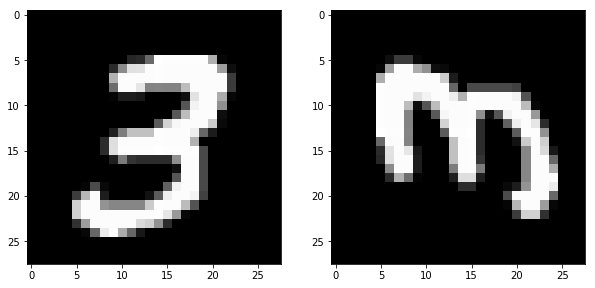

In [7]:
index = 7
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(np.reshape(x_train0[index], (28, 28)), cmap="gray")
fig.add_subplot(1,2,2)
plt.imshow(np.reshape(x_train90[index], (28, 28)), cmap="gray")

## Initialize the parameters

In [8]:
#--- Define Shapes
n_inputs=x_train0.shape[1] # number of input neurons = the number of features X_train

#--- Input Layer 
visible = tf.keras.Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=256, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
middle = Dense(units=128, activation='linear', activity_regularizer=tf.keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
d = Dense(units=256, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(d)

# Define denoising autoencoder model
model = tf.keras.models.Model(inputs=visible, outputs=output, name='Rotate90-Autoencoder-Model')

# Compile denoising autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

Model: "Rotate90-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Encoder-Layer (Dense)       (None, 256)               200960    
                                                                 
 Encoder-Layer-Normalization  (None, 256)              1024      
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 256)              0         
 eakyReLU)                                                       
                                                                 
 Middle-Hidden-Layer (Dense)  (None, 128)              32896     
                                                                 
 Decoder-Layer (Dense)       (None, 256)

## Train the model

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0161 - val_loss: 0.1428
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0076 - val_loss: 0.1420
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0058 - val_loss: 0.1441
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 0.1443
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 0.1426
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0039 - val_loss: 0.1431
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0036 - val_loss: 0.1454
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0035 - val_loss: 0.1432
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0033 - val_loss: 0.1431
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.003

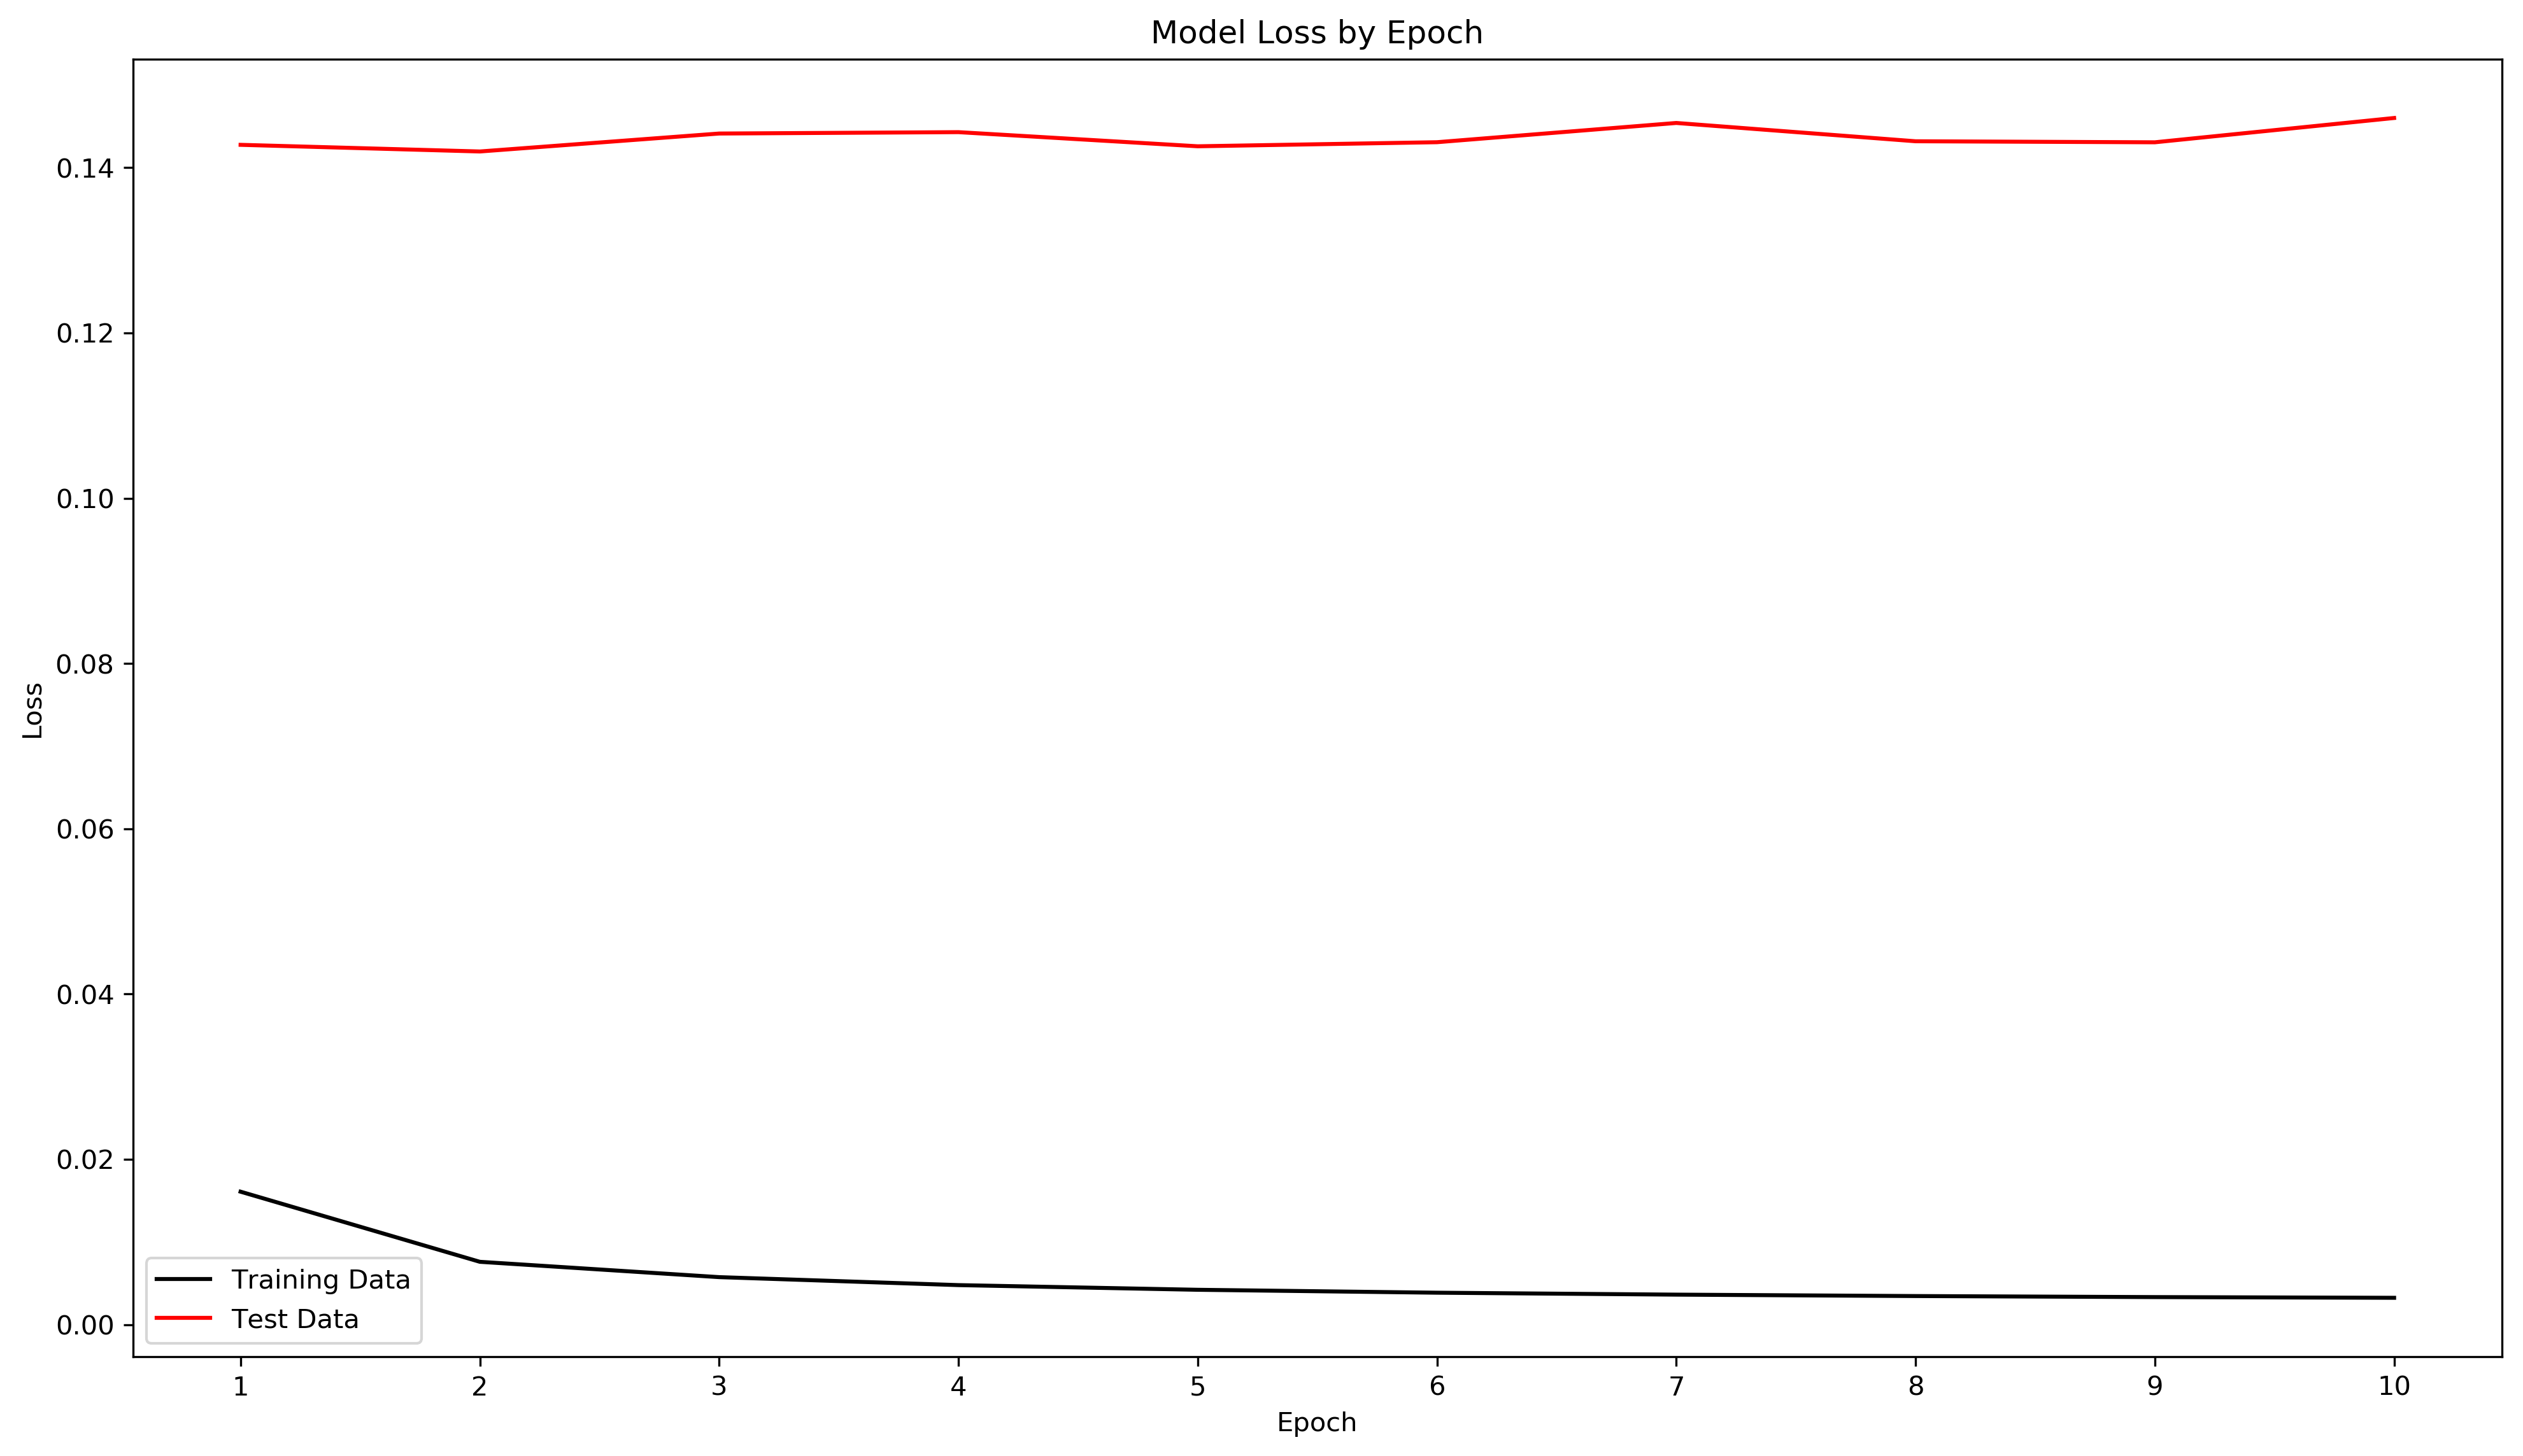

In [9]:
history = model.fit(x_train0, x_train90, epochs=10, batch_size=32, verbose=1, validation_data=(x_test0, x_test0))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

## Visualize the results

In [10]:
x_reconstruct90 = model.predict(x_test0).reshape(10000, 28, 28)

313/313 [==============================] - 1s 1ms/step


In [11]:
x_reconstruct90.shape

(10000, 28, 28)

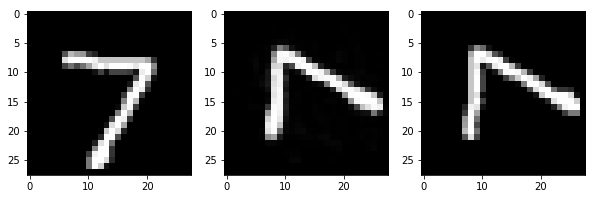

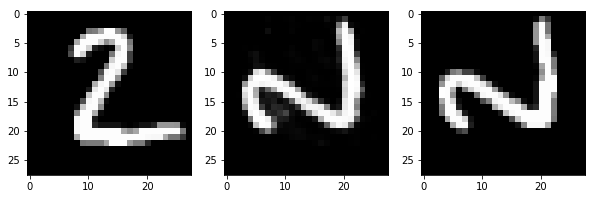

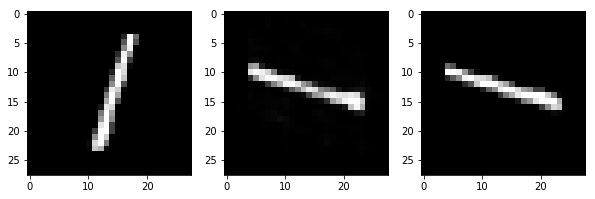

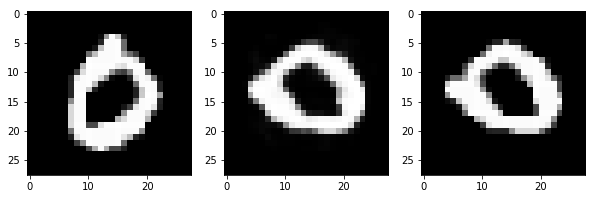

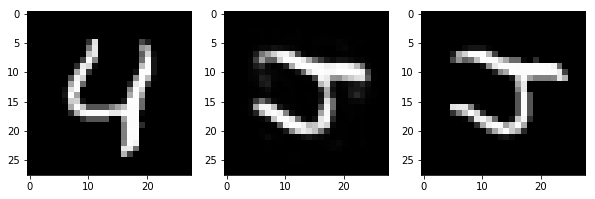

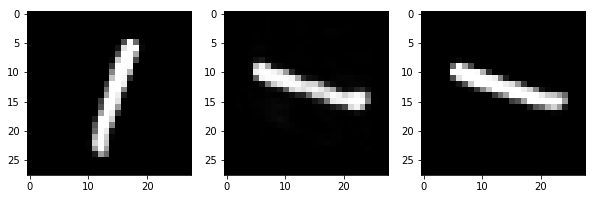

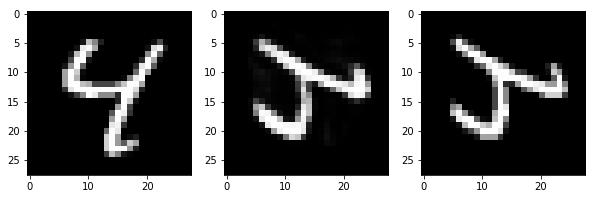

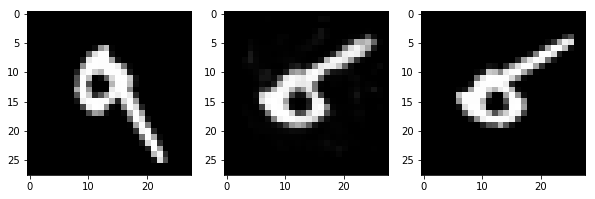

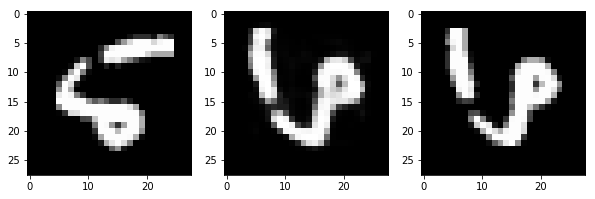

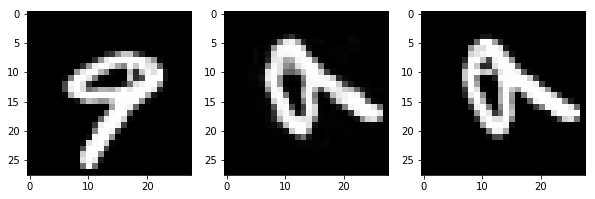

In [12]:
index = 0
t=10
for i in range(10):
    fig = plt.figure(figsize=(10, 40))
    fig.add_subplot(t,3,1)
    plt.imshow(np.reshape(x_test0[index+i], (28, 28)), cmap="gray")
    fig.add_subplot(t,3,2)
    plt.imshow(np.reshape(x_reconstruct90[index+i], (28, 28)), cmap="gray")
    fig.add_subplot(t,3,3)
    plt.imshow(np.reshape(x_test90[index+i], (28, 28)), cmap="gray")